<a href="https://colab.research.google.com/github/nahianabir/Research-Materials/blob/main/Bone_Break_Classification_with_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download/Upload Data

In [ ]:
!git clone https://github.com/ciol-researchlab/CIOL-Winter-ML-Bootcamp.git

Cloning into 'CIOL-Winter-ML-Bootcamp'...
remote: Enumerating objects: 4237, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 4237 (delta 2), reused 21 (delta 2), pack-reused 4208 (from 3)
Receiving objects: 100% (4237/4237), 105.74 MiB | 9.82 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Updating files: 100% (4061/4061), done.


# Setting up the enviroment

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Tabjular Data Analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

## Load the dataset

In [ ]:
MAIN_LOCATION = "/content/CIOL-Winter-ML-Bootcamp/datasets/session5/assignment/Bone-Break-Classification"

In [ ]:
TRAIN_DIR = os.path.join(MAIN_LOCATION, 'Train')

In [ ]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Load the training dataset
train_dataset = ImageFolder(root=TRAIN_DIR, transform=transform)

In [ ]:
# Show some sample images with labels
def show_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 8))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis('off')
    plt.show()

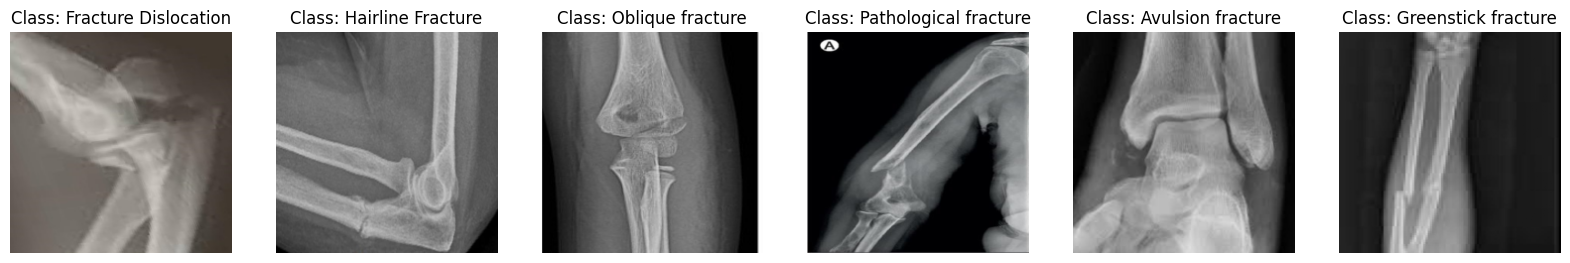

In [ ]:
show_samples(train_dataset)

## Pre-processing

In [ ]:
# Stratified split into train and validation (10% validation)
targets = [label for _, label in train_dataset.samples]
train_indices, val_indices = train_test_split(
    range(len(targets)), test_size=0.1, stratify=targets, random_state=42
)

In [ ]:
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)
print(f"Train samples: {len(train_subset)}, Validation samples: {len(val_subset)}")

Train samples: 890, Validation samples: 99


In [ ]:
# Convert datasets to Hugging Face Dataset format
def convert_to_hf_dataset(subset):
    images, labels = zip(*[subset[i] for i in range(len(subset))])
    return Dataset.from_dict({
        'image': [img.numpy() for img in images],
        'label': labels
    })

In [ ]:
hf_train_dataset = convert_to_hf_dataset(train_subset)
hf_val_dataset = convert_to_hf_dataset(val_subset)

In [ ]:
# Define a Hugging Face dataset
dataset_dict = DatasetDict({
    'train': hf_train_dataset,
    'validation': hf_val_dataset
})

In [ ]:
# Load a pre-trained model from Hugging Face
model_name = "google/vit-base-patch16-224-in21k"  # Vision Transformer model
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(
    model_name, num_labels=len(train_dataset.classes)
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from PIL import Image

def transform_example(example):
    # Convert the nested lists into a NumPy array
    img_array = np.array(example["image"], dtype=np.float32)

    # Check the shape to confirm channel position
    if img_array.shape[0] == 3:  # If it's in (C, H, W) format, transpose to (H, W, C)
        img_array = np.transpose(img_array, (1, 2, 0))

    # Ensure values are in range 0-255 for proper image processing
    img_array = (img_array * 255).astype(np.uint8)

    # Convert NumPy array to PIL image
    img = Image.fromarray(img_array)

    # Process with Hugging Face processor
    inputs = processor(images=img, return_tensors="pt")

    return {
        "pixel_values": inputs["pixel_values"].squeeze(0),  # Remove batch dimension
        "label": example["label"]
    }

In [ ]:
dataset_dict = dataset_dict.map(transform_example, remove_columns=["image"])

Map:   0%|          | 0/890 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [ ]:
print(dataset_dict["train"][0])

{'label': 0, 'pixel_values': [[[-0.8745098114013672, -0.8745098114013672, -0.8745098114013672, -0.8745098114013672, -0.8745098114013672, -0.8745098114013672, -0.8666666746139526, -0.8745098114013672, -0.8745098114013672, -0.8745098114013672, -0.8666666746139526, -0.8666666746139526, -0.8666666746139526, -0.8666666746139526, -0.8745098114013672, -0.8745098114013672, -0.8745098114013672, -0.8823529481887817, -0.8823529481887817, -0.8823529481887817, -0.8823529481887817, -0.8823529481887817, -0.8823529481887817, -0.8901960849761963, -0.8901960849761963, -0.8901960849761963, -0.8823529481887817, -0.8745098114013672, -0.8745098114013672, -0.8901960849761963, -0.8901960849761963, -0.8980392217636108, -0.8588235378265381, -0.843137264251709, -0.7568627595901489, -0.7411764860153198, -0.7254902124404907, -0.7333333492279053, -0.7411764860153198, -0.7333333492279053, -0.7254902124404907, -0.7176470756530762, -0.6941176652908325, -0.6549019813537598, -0.615686297416687, -0.5921568870544434, -0.5

## Model Training

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    run_name=None,  # Disable automatic naming
    report_to="none",  # Disable W&B logging
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Ensure logits are converted to predictions correctly
    preds = torch.argmax(torch.tensor(logits), dim=-1).numpy()

    # Avoid redundant conversion if labels are already a NumPy array
    if not isinstance(labels, np.ndarray):
        labels = labels.numpy()

    # Calculate performance metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.710600,1.912312,0.494949,0.341343,0.377387,0.403750
2,1.521000,1.826448,0.494949,0.356450,0.335715,0.412840
3,1.418300,1.759106,0.474747,0.347397,0.339546,0.398005
4,1.178000,1.704489,0.505051,0.392972,0.448405,0.428603
5,1.080800,1.652855,0.525253,0.448742,0.546006,0.468365
6,0.973300,1.609488,0.565657,0.481218,0.581380,0.496187
7,0.885600,1.582493,0.575758,0.518222,0.584132,0.523720
8,0.818300,1.573898,0.535354,0.469352,0.560505,0.476187
9,0.812000,1.556965,0.575758,0.511559,0.552594,0.517616
10,0.771400,1.553367,0.575758,0.511559,0.552594,0.517616


TrainOutput(global_step=450, training_loss=1.1395341936747234, metrics={'train_runtime': 1614.6699, 'train_samples_per_second': 5.512, 'train_steps_per_second': 0.279, 'total_flos': 6.897281585467392e+17, 'train_loss': 1.1395341936747234, 'epoch': 10.0})

**insight-**

After double training, I'm still getting an accuracy of 57%

## Results

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 1.582492709159851, 'eval_accuracy': 0.5757575757575758, 'eval_f1': 0.5182219989445053, 'eval_precision': 0.5841321616979511, 'eval_recall': 0.5237196137196137, 'eval_runtime': 24.4401, 'eval_samples_per_second': 4.051, 'eval_steps_per_second': 0.205, 'epoch': 10.0}


In [ ]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# If the image was normalized (common with pre-trained models), you need to unnormalize
# Example for a common normalization range (you can adjust it to your specific case)
mean = [0.485, 0.456, 0.406]  # These are the ImageNet means (adjust for your dataset)
std = [0.229, 0.224, 0.225]   # These are the ImageNet stds (adjust for your dataset)

def unnormalize_image(tensor, mean, std):
    # Unnormalize the image by multiplying with the std and adding the mean
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_errors(dataset, model, processor, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set model to evaluation mode
    sample_idx = 0
    for image, label in dataset:
        # Preprocess the image
        inputs = processor(images=[image], return_tensors="pt", do_rescale=False)

        # Move the inputs to the correct device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Get the predicted class
        pred = torch.argmax(outputs.logits).item()

        # Check if the prediction is incorrect
        if pred != label:
            sample_idx += 1
            if sample_idx > num_samples:
                break

            # Unnormalize and convert the tensor back to a PIL image for display
            image_tensor = image.cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
            image_tensor = torch.tensor(image_tensor)  # Convert back to tensor to apply unnormalization
            image_tensor = unnormalize_image(image_tensor, mean, std)

            # Convert to PIL Image for proper display
            image_pil = Image.fromarray(np.clip(image_tensor.numpy().astype('float32') * 255, 0, 255).astype('uint8'))

            # Plot the misclassified image
            plt.imshow(image_pil)
            plt.title(f"True: {label}, Pred: {pred}")
            plt.axis('off')
            plt.show()

            # Print the error
            print(f"True: {label}, Pred: {pred}")


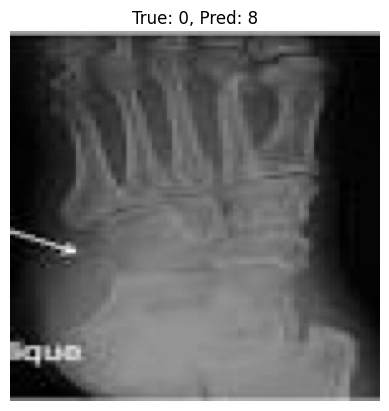

True: 0, Pred: 8


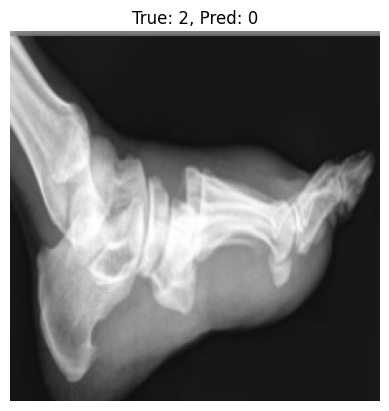

True: 2, Pred: 0


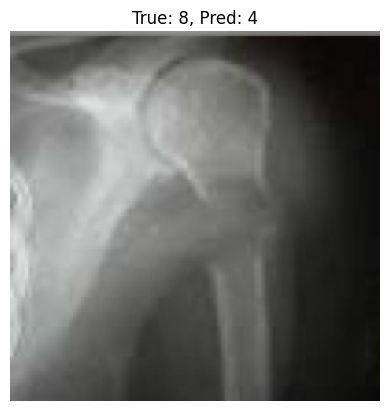

True: 8, Pred: 4


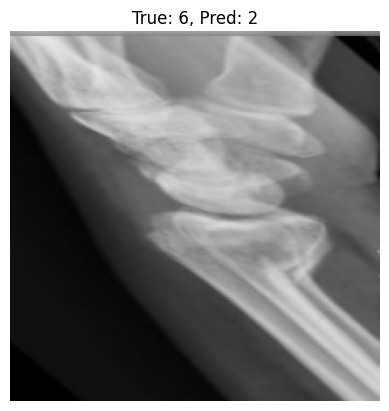

True: 6, Pred: 2


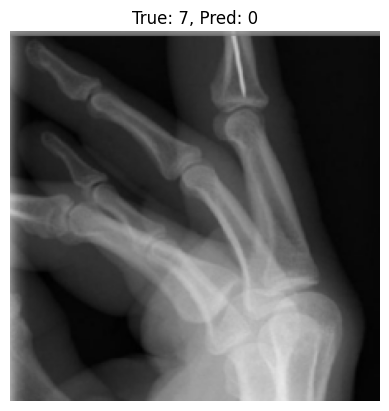

True: 7, Pred: 0


In [ ]:
show_errors(val_subset, model, processor, num_samples=5)

## Predict

In [ ]:
# Define the data directory
TEST_DIR = os.path.join(MAIN_LOCATION, 'Test')


In [ ]:
# Function to load and preprocess images
def load_test_data(image_folder):
    test_images = []
    test_labels = []
    class_names = os.listdir(image_folder)

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(image_folder, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image = Image.open(img_path).convert("RGB")
            image = transform(image)
            test_images.append(image)
            test_labels.append(label)  # Using folder index as label

    return test_images, test_labels

# Load test images and labels
test_images, test_labels = load_test_data(TEST_DIR)

In [ ]:
# Convert images and labels to tensors
test_images_tensor = torch.stack(test_images)
test_labels_tensor = torch.tensor(test_labels)

# Create a PyTorch dataset
test_dataset = torch.utils.data.TensorDataset(test_images_tensor, test_labels_tensor)

# Create a DataLoader for inference
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
MODEL_ADDRESS = "/content/results/checkpoint-405"

In [ ]:
from transformers import AutoModelForImageClassification

# Load the trained model
model = AutoModelForImageClassification.from_pretrained(MODEL_ADDRESS)
model.eval()  # Set to evaluation mode

# Run inference
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        images, labels = batch
        outputs = model(images)
        preds = torch.argmax(outputs.logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average="macro")
precision = precision_score(true_labels, predictions, average="macro")
recall = recall_score(true_labels, predictions, average="macro")

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Test Accuracy: 0.0786
Test F1 Score: 0.0737
Test Precision: 0.0814
Test Recall: 0.0767


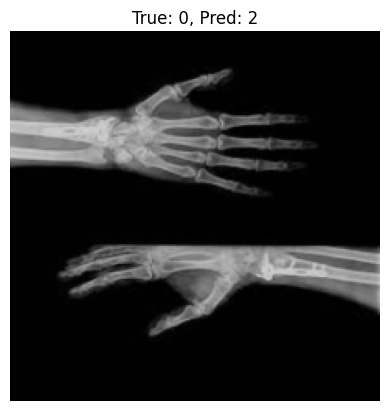

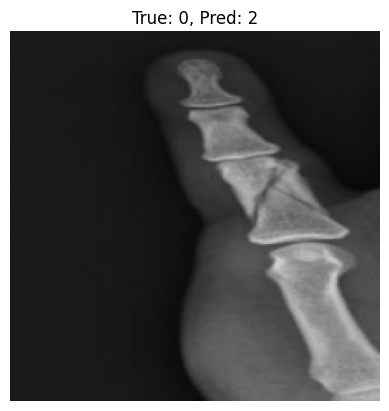

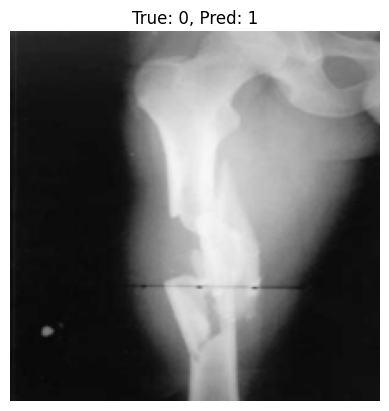

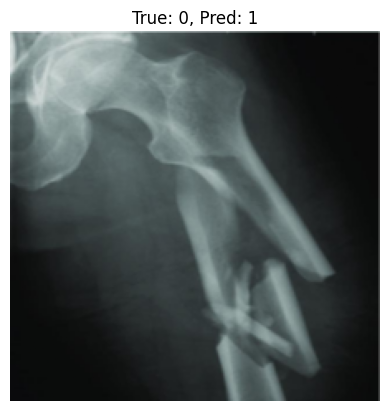

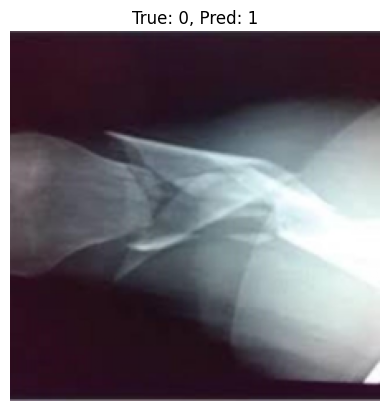

In [ ]:
# Identify misclassified examples
misclassified_idxs = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]

# Plot a few misclassified images
for idx in misclassified_idxs[:5]:  # Show first 5 misclassified images
    img = test_images_tensor[idx].permute(1, 2, 0).numpy()  # Convert to HxWxC for visualization
    plt.imshow(img)
    plt.title(f"True: {true_labels[idx]}, Pred: {predictions[idx]}")
    plt.axis("off")
    plt.show()

In [ ]:
for i in range(len(true_labels)):
    print(f"Image {i+1}: True Label - {true_labels[i]}, Predicted Label - {predictions[i]}")

Image 1: True Label - 0, Predicted Label - 2
Image 2: True Label - 0, Predicted Label - 2
Image 3: True Label - 0, Predicted Label - 1
Image 4: True Label - 0, Predicted Label - 1
Image 5: True Label - 0, Predicted Label - 1
Image 6: True Label - 0, Predicted Label - 1
Image 7: True Label - 0, Predicted Label - 2
Image 8: True Label - 0, Predicted Label - 1
Image 9: True Label - 0, Predicted Label - 2
Image 10: True Label - 0, Predicted Label - 8
Image 11: True Label - 0, Predicted Label - 2
Image 12: True Label - 0, Predicted Label - 1
Image 13: True Label - 0, Predicted Label - 1
Image 14: True Label - 0, Predicted Label - 2
Image 15: True Label - 1, Predicted Label - 3
Image 16: True Label - 1, Predicted Label - 3
Image 17: True Label - 1, Predicted Label - 3
Image 18: True Label - 1, Predicted Label - 3
Image 19: True Label - 1, Predicted Label - 2
Image 20: True Label - 1, Predicted Label - 3
Image 21: True Label - 1, Predicted Label - 2
Image 22: True Label - 1, Predicted Label -

# **insight-**

Many of predictions are wrong. maybe the data is underfitting.